In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

scaler = MinMaxScaler()

### Number of advisors per hour

In [2]:
gs_uri = 'gs://videotron-ai-bucket/'
dataset_path = gs_uri + 'dataset/'
df = pd.read_excel(dataset_path + 'Planning intra-day 2020-01-01 au 2020-04-30.xlsx')
df = df.fillna(0.0)
df.head()

,Stauts,Date nominale,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
0,Logged in,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,2,1,1,1,1,1,1,1,1,1
1,Logged in,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,6,4,4,3,2,2,1,1,1,1
2,Logged in,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,...,9,7,5,3,3,2,2,1,2,2
3,Logged in,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,3,2,2,2,1,1,1,1,1
4,Logged in,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,3,2,2,2,2,1,1,1,1,1


In [3]:
# Most calls happen in this period
cols = ['08:00', '09:00', '10:00', '11:00', '12:00',
        '13:00', '14:00', '15:00', '16:00', '17:00']
df['date'] = pd.to_datetime(df['Date nominale'])
df['avg_num_adv'] = df[cols].mean(axis=1)
advisor_df = df[['date', 'avg_num_adv']]

### Daily Performance

In [4]:
perf = pd.read_csv(dataset_path + 'performance_centre_appels_sept2017_mars2020.csv', encoding='iso-8859-1')
perf.columns = ['week_day', 'date', 'total_calls', 'accept', 'accept_percent', 'abandon', 'abandon_percent',
                'SLA', 'avg_time_treat', 'avg_time_engage', 'avg_time_accept', 'avg_time_abadon', 
                'max_time_accept', 'max_time_abandon', 'accept_percent_no_attend', 'abandon_during_ring',
                'abandon_short', 'other']
perf.head()

,week_day,date,total_calls,accept,accept_percent,abandon,abandon_percent,SLA,avg_time_treat,avg_time_engage,avg_time_accept,avg_time_abadon,max_time_accept,max_time_abandon,accept_percent_no_attend,abandon_during_ring,abandon_short,other
0,Vendredi,2017-09-01,448,410,0.915179,38,0.084821,0.658482,487.897561,436.109756,124.582927,137.973684,962,849,0.243902,0,1,0
1,Samedi,2017-09-02,142,133,0.936620,9,0.063380,0.802817,364.285714,333.285714,78.804511,161.111111,1441,369,0.721805,0,0,0
2,Dimanche,2017-09-03,113,106,0.938053,7,0.061947,0.867257,279.584906,259.566038,51.481132,114.714286,402,354,0.471698,0,2,0
3,Lundi,2017-09-04,205,186,0.907317,19,0.092683,0.863415,407.005376,382.005376,27.666667,231.944444,449,1021,0.774194,1,2,0
4,Mardi,2017-09-05,787,698,0.886912,89,0.113088,0.592122,417.938395,381.512894,146.882521,148.918605,683,681,0.163324,3,4,1


### Average daily abandon percentage

#### KPI: % Drop goal 10%: Percentage Total of abandoned calls per day. The objective is to reach an average daily percentage of abandoned calls less than or equal to 10% of all calls Receipts



- Current average daily percentage of abandoned calls is 20% for year 2020
- Given correlation between abandon percentage and average wait time, reducing average wait time will decrease abandon percentage

### Correlation between average waiting time and abandon percentage

In [8]:
100*test['abandon_percent'].mean()

20.132015475555555

Abandon percentage: 20.13%
Corr coef: 0.8150, p-value: 1.44e-22


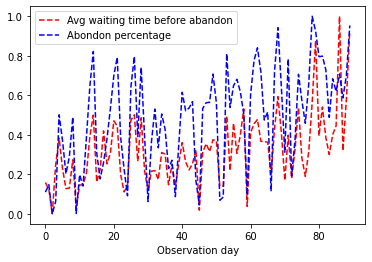

In [16]:
perf['avg_time_accept_min'] = perf['avg_time_accept'] / 60.
perf['avg_time_abandon_min'] = perf['avg_time_abadon'] / 60.
perf['abandon_percentage'] = perf['abandon_percent'] * 100.
test = perf[perf['date'] > '2020-01-01']

#
mean_abandon = 100*test['abandon_percent'].mean()
print('Abandon percentage: %.2f%%' % mean_abandon)

# Do a pearson correlation analysis
pearson_r , p_val = stats.pearsonr(test['avg_time_abandon_min'], test['abandon_percentage'])
print('Corr coef: %.4f, p-value: %.2e' % (pearson_r , p_val))

x  = range(test.shape[0])

# Scale the data
scaler.fit(test[['avg_time_abandon_min', 'abandon_percentage']])
y = scaler.transform(test[['avg_time_abandon_min', 'abandon_percentage']])
y1 = y[:, 0]
y2 = y[:, 1]


plt.plot(x, y1, 'r--', label='Avg waiting time before abandon') 
plt.plot(x, y2, 'b--', label='Abondon percentage')
plt.xlabel('Observation day')
plt.legend()
plt.show()

In [ ]:
# Abandon percentage when average wait time < 7 mins
WAITING_TIME_GOAL = 7

avg_abandon_percent_desired = test[test['avg_time_abandon_min'] <= WAITING_TIME_GOAL][['abandon_percentage']].mean()
avg_abandon_percent_desired

### Daily wait time

#### KPI: Waiting time of 550h 300h Weekly goal: On average currently waiting the weekly rate is 550h. We want to reduce this waiting time to an average of 300 hours per week (Monday to Sunday week?)

- Dependent on volume of calls
- Based on calculations below, optimum average wait time is **7 minutes** to keep average waiting weekly rate to be 300 +- 13 in 2020

- **time to lose**: means we could've let the clients wait more time to reduce call center capacity
- **time to gain**: means we should answer quicker -> increase capacity


#### Assumption: We assume that if given the perfectly accurate prediction of number of calls, the call center management will be able to allocate exact number of advisors to keep desire average wait time

In [ ]:
test

In [ ]:
test['accept_time_gains']  = (test['avg_time_accept_min']  - WAITING_TIME_GOAL) * test['accept']  / 60
test['abandon_time_gains'] = (test['avg_time_abandon_min'] - WAITING_TIME_GOAL) * test['abandon'] / 60

print("accept time to lose", test.loc[test['accept_time_gains'] < 0, 'accept_time_gains'].sum(), 'hours')
print("accept time to gain", test.loc[test['accept_time_gains'] > 0, 'accept_time_gains'].sum(), 'hours')
#
print("abandon time to lose", test.loc[test['abandon_time_gains'] < 0, 'abandon_time_gains'].sum(), 'hours')
print("abandon time to gain", test.loc[test['abandon_time_gains'] > 0, 'abandon_time_gains'].sum(), 'hours')

### Weekly wait time

In [ ]:
perf['total_time_accept']  = (perf['avg_time_accept'] * perf['accept']) / (60 * 60)
perf['total_time_abandon'] = (perf['avg_time_abadon'] * perf['abandon']) /  (60 * 60)
perf['total_time_desire']  = perf['total_calls'] * WAITING_TIME_GOAL / 60
#
perf['date'] = pd.to_datetime(perf['date'])

In [ ]:
out = perf[['date', 'total_time_accept', 'total_time_abandon', 'total_time_desire']]
out = perf.resample('W-Mon', on='date')\
          .agg({'total_time_accept' : np.sum, 
                'total_time_abandon' : np.sum,
                'total_time_desire' : np.sum}).reset_index()\
          .sort_values(by='date')
#
print(out[out['date'] > '2020-01-01']['total_time_desire'].mean())
out[out['date'] > '2020-01-01']

### Join with number of advisors

- Can get the number of calls per hour to join with number of advisors per hour for next step


### Temporary Conclusion

- if ratio between average number of call volume per hour and average number of advisors per hours is < 5, then average wait time should be within 7 minutes desired wait time

In [ ]:
test = test[['date', 'total_calls', 'accept_percent', 'abandon_percent', 'avg_time_accept_min', 'avg_time_abandon_min']]
test['date'] = pd.to_datetime(test['date'])
test = test.merge(advisor_df, on='date', how='inner')
test['ratio_call_advisor'] = (test['total_calls'] / 10) / test['avg_num_adv']
#
test[(test['avg_time_accept_min'] < WAITING_TIME_GOAL) & (test['avg_time_abandon_min'] < WAITING_TIME_GOAL)]['ratio_call_advisor'].mean()

In [ ]:
test[(test['avg_time_accept_min'] > WAITING_TIME_GOAL) & (test['avg_time_abandon_min'] > WAITING_TIME_GOAL)]['ratio_call_advisor'].mean()